# PLOTS FOR AREA ENERGY EFFICIENCY

In [25]:
import matplotlib.pyplot as plt
import numpy as np 
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d

from Functions import *

In [38]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 10
# gamma = db2pow(20)
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

# Network Parameters
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 0.1 #in watts
NUM_SIMULATIONS = 100

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1
omega = np.sqrt(0.5)

# Path Loss Parameters
ALPHA = 2.2 #path loss exponent (indirect - IRS 1)
BETA = 3.8 #path loss exponent  (indirect - IRS 1)
ZETA = 3.8 #path loss exponent  (direct)

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

# Generate BS position
xt, yt, zt = BASE_STATION_POSITION
loc_T = np.array([BASE_STATION_POSITION])

# Generating channels

In [39]:
h_dk_3d = np.zeros((NUM_SIMULATIONS,K,1), dtype= np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS,Ns,K), dtype= np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns), dtype= np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS,Ns,1), dtype= np.complex128)
h_rk2_3d = np.zeros((NUM_SIMULATIONS,Ns,K), dtype= np.complex128)
h_rk2_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns), dtype= np.complex128) 
G2_3d = np.zeros((NUM_SIMULATIONS,Ns,1), dtype= np.complex128)

# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk = np.zeros((K,1))
    h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
    h_dk = np.reshape(h_dk ,(K,1))
    h_dk_3d[i] = h_dk
    
    # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns)) 
    h_rk1 = fading
    h_rk1 = np.reshape(h_rk1,(Ns,K))
    h_rk1_transpose = np.transpose(h_rk1)
    h_rk1_h = np.conj(h_rk1_transpose)
    h_rk1_3d[i] = h_rk1
    h_rk1_h_3d[i] = h_rk1_h


    # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns)) 
    h_rk2 = fading
    h_rk2 = np.reshape(h_rk2,(Ns,K))
    h_rk2_transpose = np.transpose(h_rk2)
    h_rk2_h = np.conj(h_rk2_transpose)
    h_rk2_3d[i] = h_rk2
    h_rk2_h_3d[i] = h_rk2_h

    # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
    G1 = generate_nakagami_samples(m,omega,Ns) 
    G1 = np.reshape(G1,(Ns,1))
    G1_3d[i] = G1

    # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
    G2 = generate_nakagami_samples(m,omega,Ns)
    G2 = np.reshape(G2,(Ns,1))
    G2_3d[i] = G2

print('Size of hdk3d', np.shape(h_dk_3d))
print('Size of hrk3d', np.shape(h_rk1_3d))
print('Size of hrkh3d', np.shape(h_rk1_h_3d))
print('Size of g3d', np.shape(G1_3d))

Size of hdk3d (100, 10, 1)
Size of hrk3d (100, 100, 10)
Size of hrkh3d (100, 10, 100)
Size of g3d (100, 100, 1)


In [40]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# BS to IRS
G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)    
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)

In [41]:
grid_radius_array = np.arange(100,1001,100)

# Define empty lists
grid_area_list = []
IRS_POSITION_1_list = []
IRS_POSITION_2_list = []
loc_U_list = []

# Usage within the loop
for GRID_RADIUS in grid_radius_array:
    
    # Function calculate_values_for_radius returns the following 4 quantities
    grid_area, IRS_POSITION_1, IRS_POSITION_2, loc_U = calculate_values_for_radius(GRID_RADIUS, K) 

    # Append the values to the respective lists
    grid_area_list.append(grid_area)
    IRS_POSITION_1_list.append(IRS_POSITION_1)
    IRS_POSITION_2_list.append(IRS_POSITION_2)
    loc_U_list.append(loc_U)

# print(grid_area_list[9])
# print()
# print(IRS_POSITION_1_list[9])
# print()
# print(IRS_POSITION_2_list[9])
# print()
# print(loc_U_list[5])
# print()

# DOUBLE IRS CASE (IDEAL, CONTINUOUS)

In [42]:
B = None
RATE_THRESHOLD = 10

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_1 = []
area_spectral_efficiency_1 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    IRS_position_1 = IRS_POSITION_1_list[i]
    xs_1, ys_1, zs_1 = IRS_POSITION_1

    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()
    
    # Generate IRS position_2
    IRS_position_2 = IRS_POSITION_2_list[i]
    xs_2, ys_2, zs_2 = IRS_POSITION_2

    irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_2 = irs_coords_2
    # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
    # print()

    loc_U = loc_U_list[i]
    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)
    # Compute row-wise averages
    dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
    dSU_2 = dSU_2.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_2 = np.mean(dTS_2, axis=1)
    # Compute the average of row sums
    dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
    h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
        theta_2 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)

        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**ALPHA)*(dTS_2**BETA)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_22 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(AEE) 

    # Compute the average area energy efficiency
    area_energy_efficiency_1.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_1.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_1)

done
[2465.0134128503946, 624.963208144054, 277.7234428258525, 153.3357225648129, 106.57354239107971, 69.51541831578604, 48.98116112210751, 40.47093217823571, 28.967023595512725, 26.25559149902102]


In [31]:
# # Create a bar graph
# bar_width = 50
# plt.bar(grid_radius_array, area_energy_efficiency_1, color='blue', alpha=1, width=bar_width)
# plt.ylabel('Area Energy Efficiency')
# plt.xlabel('Radius of the grid')
# plt.title('Area Energy Efficiency Vs Grid Radius')
# plt.show()

# DOUBLE IRS CASE (PRACTICAL, DISCRETE WITH B = 3)

In [43]:
RATE_THRESHOLD = 10
B = 3

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

area_energy_efficiency_2 = []
area_spectral_efficiency_2 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    IRS_position_1 = IRS_POSITION_1_list[i]
    xs_1, ys_1, zs_1 = IRS_POSITION_1

    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()
    
    # Generate IRS position_2
    IRS_position_2 = IRS_POSITION_2_list[i]
    xs_2, ys_2, zs_2 = IRS_POSITION_2

    irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_2 = irs_coords_2
    # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
    # print()

    loc_U = loc_U_list[i]
    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)
    # Compute row-wise averages
    dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
    dSU_2 = dSU_2.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_2 = np.mean(dTS_2, axis=1)
    # Compute the average of row sums
    dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
    h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
        theta_2 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**ALPHA)*(dTS_2**BETA)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_22 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(AEE) 

    # Compute the average area energy efficiency
    area_energy_efficiency_2.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_2.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_2)

done
[3765.6935020145697, 957.8737573384827, 426.16930942288616, 234.2207127196496, 165.01080786891723, 106.3027107266282, 74.65086522658055, 62.603710811632155, 43.76121581882755, 40.73746038761943]


# SINGLE IRS CASE (IDEAL, CONTINUOUS)

In [44]:
B = None

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_3 = []
area_spectral_efficiency_3 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    IRS_position_1 = IRS_POSITION_1_list[i]
    xs_1, ys_1, zs_1 = IRS_POSITION_1

    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()

    loc_U = loc_U_list[i]
    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None )
        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_1**ALPHA)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_2 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_2 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(AEE) 

    # Compute the average area energy efficiency
    area_energy_efficiency_3.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_3.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_3)

done
[2859.1836369422344, 732.5375321767378, 327.2938659435129, 172.07337145078588, 130.7270620635666, 78.72692693829185, 56.41608047278471, 48.850090037806986, 29.775408354719094, 30.951870673775304]


# SINGLE IRS CASE (PRACTICAL, DISCRETE with B=3)

In [45]:
B = 3

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

area_energy_efficiency_4 = []
area_spectral_efficiency_4 = []

for i in range(len(grid_radius_array)):

    grid_area = grid_area_list[i]
    
    # Generate IRS position_1
    IRS_position_1 = IRS_POSITION_1_list[i]
    xs_1, ys_1, zs_1 = IRS_POSITION_1

    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()

    loc_U = loc_U_list[i]
    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Initialize list to store area_energy_efficiency
    area_energy_efficiency = []
    
    # Initialize area_spectral_efficiency for this case
    area_spectral_efficiency = []

    # Perform simulations
    for s in range(NUM_SIMULATIONS):
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range(K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_1**ALPHA)))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

        # Calculate the Area Spectral Efficiency (ASE)
        ASE = arr_sumrate_disc[s]/grid_area
        area_spectral_efficiency.append(ASE)

        # Calculate the total power of the system
        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_2 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_2 + power_3

        # Compute the energy efficiency and the Area Energy Efficiency (AEE)
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        AEE = ASE/P # Using the ASE and total power
        area_energy_efficiency.append(AEE) 

    # Compute the average area energy efficiency
    area_energy_efficiency_4.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
    
    # Append the average ASE for this T to the list
    area_spectral_efficiency_4.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))
    
print('done')
print(area_energy_efficiency_4)

done
[3451.526375869524, 889.0880491302662, 398.14272315892254, 207.030016691883, 162.6402217853456, 95.2020568565741, 67.92517622430246, 60.223947054494865, 34.811824500605184, 38.31511884820351]


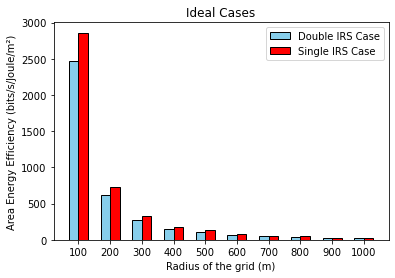

In [46]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(area_energy_efficiency_1))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, area_energy_efficiency_1, color='skyblue', width=bar_width, edgecolor='black', label='Double IRS Case')
plt.bar(r2, area_energy_efficiency_3, color='red', width=bar_width, edgecolor='black', label='Single IRS Case')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Area Energy Efficiency (bits/s/Joule/m²)')
plt.title('Ideal Cases')
plt.xticks([r + bar_width / 2 for r in range(len(area_energy_efficiency_1))], grid_radius_array)
plt.legend()
plt.show()

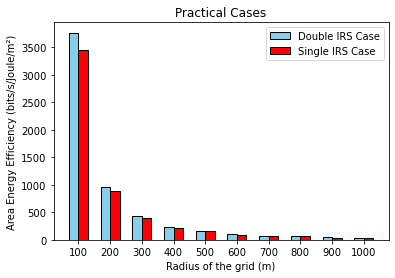

In [47]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(area_energy_efficiency_2))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, area_energy_efficiency_2, color='skyblue', width=bar_width, edgecolor='black', label='Double IRS Case')
plt.bar(r2, area_energy_efficiency_4, color='red', width=bar_width, edgecolor='black', label='Single IRS Case')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Area Energy Efficiency (bits/s/Joule/m²)')
plt.title('Practical Cases')
plt.xticks([r + bar_width / 2 for r in range(len(area_energy_efficiency_2))], grid_radius_array)
plt.legend()
plt.show()